In [227]:
import numpy as np
import pandas as pd

import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import re

from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt

from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve
from sklearn.utils.multiclass import unique_labels

from fastai.text import *

from IPython.display import display_html

### Allows showing dataframes side by side by changing to inline styling

In [169]:
def display_dataframes_inline(*dataframes):
    inline_df = "".join([df.to_html() for df in dataframes]).replace("table", "table style='display: inline'")
    display_html(inline_df, raw=True)

In [305]:
pd.set_option('max_colwidth', 200)
isear_df = pd.read_csv("../corpora/isear.csv", header=None)
isear_df.columns = ["emotion", "text", ""]
isear_df = isear_df.drop([""], axis=1)
isear_df.head()

,emotion,text
0,joy,On days when I feel close to my partner and other friends. \nWhen I feel at peace with myself and also experience a close \ncontact with people whom I regard greatly.
1,fear,"Every time I imagine that someone I love or I could contact a \nserious illness, even death."
2,anger,When I had been obviously unjustly treated and had no possibility \nof elucidating this.
3,sadness,When I think about the short time that we live and relate it to \nthe periods of my life when I think that I did not use this \nshort time.
4,disgust,At a gathering I found myself involuntarily sitting next to two \npeople who expressed opinions that I considered very low and \ndiscriminating.


In [84]:
def clean_text(content):
    content = content.lower().strip()
    content = re.sub(r"[^a-zA-Z]", " ", str(content))
    tokens = [word for word in content.split() if word and word not in stopwords.words("english")]
    cleaned_text = " ".join(tokens)
    return cleaned_text

In [47]:
cleaned_text = [clean_text(text) for text in isear_df["text"].tolist()]

In [50]:
X_train, X_test, Y_train, Y_test = train_test_split(cleaned_text, isear_df["emotion"].tolist(), test_size=0.3, random_state=1)

In [49]:
isear_df.groupby("emotion").count()

,text
emotion,
anger,1079
disgust,1066
fear,1076
guilt,1050
joy,1092
sadness,1082
shame,1071


In [157]:
def print_confusion_matrix(prediction, Y_test, categories):
    cm = confusion_matrix(Y_test, prediction)
    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=list(categories), yticklabels=list(categories),
           title="Emotion Classification Confusion Matrix",
           ylabel='Actual Emotion',
           xlabel='Predicted Emotion')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], "0.0f"), ha="center", va="center", color="white" if cm[i, j] > thresh else "black")
    fig

In [160]:
def test_classifier_accuracy(classifier):
    classifier.fit(X_train, Y_train)
    prediction = classifier.predict(X_test)
    print(classification_report(Y_test, prediction))
    print("Accuracy:", accuracy_score(prediction, Y_test))

    print_confusion_matrix(prediction, Y_test, classifier.classes_)

In [138]:
count_vectorizer = CountVectorizer()
training_counts = count_vectorizer.fit_transform(cleaned_text)
training_counts.shape

(7516, 8702)

In [139]:
tfidf_transformer = TfidfTransformer()

In [140]:
bag_of_words = count_vectorizer.transform(cleaned_text)
sum_words = bag_of_words.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in count_vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)

### Show top words in dataset

In [141]:
tfidf_transformer.fit(bag_of_words)
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=count_vectorizer.get_feature_names(),columns=["idf_weights"])
df_idf.sort_values(by=['idf_weights']).head(15)

,idf_weights
friend,3.130336
felt,3.174991
one,3.434199
time,3.600563
got,3.877550
home,3.990028
mother,4.006029
friends,4.008720
told,4.008720
would,4.058454


In [142]:
category_top_words = {}
for category in isear_df.groupby("emotion").count().index.tolist():
    cleaned_cat = [clean_text(text) for text in isear_df[isear_df["emotion"] == category].text.tolist()]
    tfidf_transformer.fit(count_vectorizer.transform(cleaned_cat))
    df_idf = pd.DataFrame(tfidf_transformer.idf_, index=count_vectorizer.get_feature_names(), columns=["idf_weights"])
    category_top_words[category] = df_idf.sort_values(by=['idf_weights']).head(15)

In [143]:
category_top_words.keys()

dict_keys(['anger', 'disgust', 'fear', 'guilt', 'joy', 'sadness', 'shame'])

### Show top words per category

In [170]:
for category, df in category_top_words.items():
    df.index.name = category

display_dataframes_inline(*[df for _, df in category_top_words.items()])

,idf_weights
anger,
angry,2.764360
friend,2.928471
one,3.340325
got,3.615268
time,3.640911
told,3.680651
felt,3.736221
person,3.841582
people,3.873842


### Naive Bayes model acts as a baseline measurement for comparison with better models

              precision    recall  f1-score   support

       anger       0.48      0.37      0.42       331
     disgust       0.67      0.49      0.57       324
        fear       0.62      0.67      0.65       311
       guilt       0.40      0.52      0.45       299
         joy       0.58      0.74      0.65       323
     sadness       0.62      0.60      0.61       351
       shame       0.50      0.46      0.48       316

   micro avg       0.55      0.55      0.55      2255
   macro avg       0.55      0.55      0.55      2255
weighted avg       0.56      0.55      0.55      2255

Accuracy: 0.5494456762749446


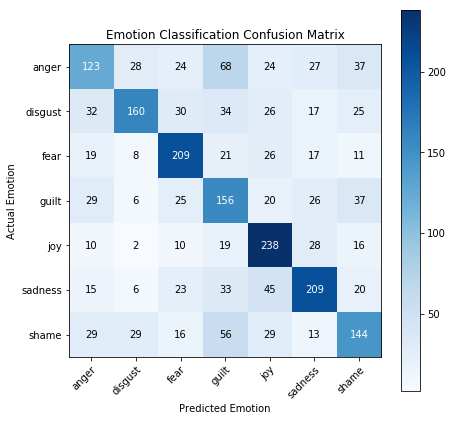

In [162]:
naive_bayes = Pipeline([
        ('vect', count_vectorizer), 
        ('tfidf', tfidf_transformer), 
        ('clf', MultinomialNB())
    ])
test_classifier_accuracy(naive_bayes)

              precision    recall  f1-score   support

       anger       0.43      0.47      0.45       331
     disgust       0.53      0.55      0.54       324
        fear       0.67      0.68      0.68       311
       guilt       0.47      0.46      0.47       299
         joy       0.63      0.72      0.67       323
     sadness       0.70      0.62      0.66       351
       shame       0.51      0.44      0.47       316

   micro avg       0.56      0.56      0.56      2255
   macro avg       0.56      0.56      0.56      2255
weighted avg       0.57      0.56      0.56      2255

Accuracy: 0.564079822616408


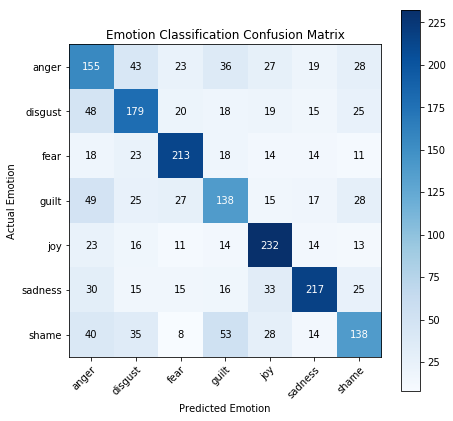

In [166]:
log_regression = Pipeline([
        ('vect', count_vectorizer), 
        ('tfidf', tfidf_transformer),
        ('clf', SGDClassifier(loss="log", 
                              penalty='l1',
                              random_state=1
                             ))
    ])
test_classifier_accuracy(log_regression)

              precision    recall  f1-score   support

       anger       0.46      0.45      0.46       331
     disgust       0.59      0.58      0.58       324
        fear       0.65      0.71      0.68       311
       guilt       0.47      0.52      0.49       299
         joy       0.61      0.72      0.66       323
     sadness       0.68      0.62      0.64       351
       shame       0.55      0.41      0.47       316

   micro avg       0.57      0.57      0.57      2255
   macro avg       0.57      0.57      0.57      2255
weighted avg       0.57      0.57      0.57      2255

Accuracy: 0.572949002217295


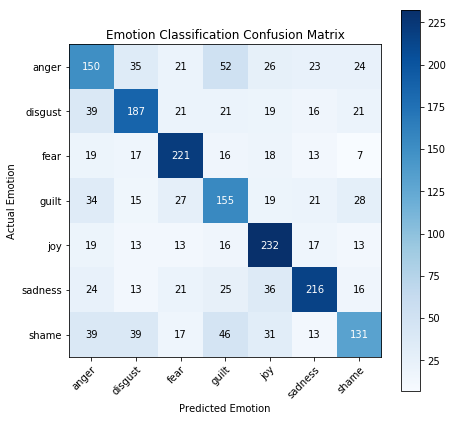

In [165]:
svm = Pipeline([
        ('vect', count_vectorizer), 
        ('tfidf', tfidf_transformer),
        ('clf', SGDClassifier(
            loss="hinge", 
            random_state=1
        ))
    ])
test_classifier_accuracy(svm)

In [167]:
def get_class_probs(classifier, data):
    prob_spread = classifier.predict_proba([data]).tolist()[0] if hasattr(classifier, "predict_proba") else None
    probabilities = pd.DataFrame({"class": classifier.classes_, "probability": prob_spread})
    probabilities = probabilities.sort_values(by="probability", ascending=False)
    probabilities = probabilities.set_index("class").T.reset_index()
    del probabilities["index"]
    probabilities["predicted"] = log_regression.predict([data])
    return probabilities

### Test the Scikit models and get a spread of certainty for different emotions

In [168]:
sample = "I'm happy!"

print("Category Prediction: {}".format(svm.predict([sample])[0]))
probs = get_class_probs(log_regression, sample)
display(probs)

Category Prediction: joy


class,joy,disgust,sadness,anger,guilt,fear,shame,predicted
0,0.933373,0.026968,0.016754,0.012062,0.006031,0.002697,0.002115,joy


## Explore using FastAI 

In [224]:
def stratified_split(df, training=0.6, testing=0.2, seed=1):
    train_df = pd.DataFrame(columns=["emotion", "text"])
    test_df = pd.DataFrame(columns=["emotion", "text"])
    valid_df = pd.DataFrame(columns=["emotion", "text"])
    
    categories = df["emotion"].unique()
    for category in categories:
        category_train_sample = df[df["emotion"] == category].sample(frac=training, random_state=seed)
        train_df = pd.concat([train_df, category_train_sample], sort=False)

        temp = df.drop(category_train_sample.index)
        
        category_test_sample = temp[temp["emotion"] == category].sample(frac=testing/(1-training), random_state=seed)
        test_df = pd.concat([test_df, category_test_sample], sort=False)
        
        category_valid_sample = temp.drop(category_test_sample.index)
        valid_df = pd.concat([valid_df, category_valid_sample.query(f"emotion == '{category}'")], sort=False)
    
    return (train_df, test_df, valid_df)

In [260]:
# isear_df.head()

,emotion,text
0,joy,On days when I feel close to my partner and ot...
1,fear,Every time I imagine that someone I love or I ...
2,anger,When I had been obviously unjustly treated and...
3,sadness,When I think about the short time that we live...
4,disgust,At a gathering I found myself involuntarily si...


In [273]:
# cleaned_df = isear_df.copy()
# cleaned_df[["text"]] = cleaned_df[["text"]].apply(lambda texts: [clean_text(text) for text in texts])
# train_df, test_df, valid_df = stratified_split(cleaned_df)

In [274]:
# bs = 48

In [275]:
# language_model_data = (TextLMDataBunch.from_df("../models/", train_df=train_df, valid_df=valid_df, test_df=test_df, text_cols="text", label_cols="emotion", bs=bs))
# language_model_data.save("emotion_lm.pkl")

In [279]:
# language_model_data = load_data("../models/", "emotion_lm.pkl", bs=bs)
# language_model_data.show_batch() 

idx,text
0,telling xxunk national xxunk p felt happy xxunk xxbos got good grade exam statistics xxbos final marks given morning wanted get late afraid arrived everybody happy also passed wonderful time day long xxbos came one time met girl expect fall love fortunately tried luck accepted proposal time giving lot money like miracle xxbos party met old friend adult education course met years thought lot wonderful experience xxbos went see entrance
1,beach xxunk went beach xxunk xxbos anatomy alone first time xxbos study tour got confirmed happy time till tour began xxbos friend came tell father invited go holiday xxunk otherwise could afford go holiday xxbos saw person seen long time xxbos experienced joy got results made second year xxbos told selected attend medical assistant training xxbos went pub large group friends drank danced xxbos close relative mine xxunk difficult operation
2,accept offer marriage xxbos application studying masters degree accepted xxbos father bought suit xxbos passing exam expect pass xxbos discovered friend would xxunk first call emotion accompanied great relief xxunk year xxunk xxunk xxunk xxbos summer received grade cards ta expected b better computer science looked card got ecstatic xxbos happened finally confirmed stood first university exams days official results declared clerk brought results xxunk expecting results xxunk allowed xxunk
3,travelled far miss feel joy xxunk life taking right direction wants feel joy mainly xxbos heard selected university xxbos spontaneous picnic sister friend children great xxbos sensed strong feeling joy plant working place got message admitted full time student higher agricultural institute xxbos day got know would get shared xxunk boyfriend parents place getting little crowded growing bother wanting room first felt doubt joy also sadness feeling joy strongest xxbos
4,xxbos cycling spring xxunk gives xxunk happiness healthy wonderful finance simply earth xxbos reading nice book talking friend xxbos bought car xxbos relatives visiting xxbos xxunk student psychology xxbos passed b exams parents allowed carry studies happy xxbos got first compound column xxbos felt joy admitted higher agricultural institute xxbos learned admitted study wanted xxunk narrow xxunk general one xxbos came across friend lost touch long time xxbos finished exams


In [280]:
# emotion_learner = language_model_learner(language_model_data, AWD_LSTM, drop_mult=0.3)

In [281]:
# emotion_learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


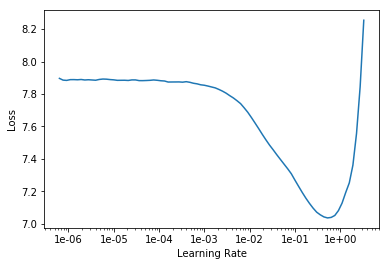

In [282]:
# emotion_learner.recorder.plot()

In [283]:
# emotion_learner.fit_one_cycle(1, 1e-1, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,6.803300,5.920916,0.134345,00:49


In [284]:
# emotion_learner.save("../models/emotion_first_cycle")

In [285]:
# emotion_learner.load("../models/emotion_first_cycle")

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (4510 items)
x: LMTextList
xxbos got good grade one midterms weeks ago,xxbos talking nice girl,xxbos brother born,xxbos basketball team xxunk xxunk play currently,xxbos country ski championship
y: LMLabelList
,,,,
Path: ../models;

Valid: LabelList (1504 items)
x: LMTextList
xxbos trip xxunk competition,xxbos day told accepted student economics,xxbos new year eve met girlfriend stood steps outside parents home kissed first time,xxbos told quite unexpectedly one wanted become vice xxunk student xxunk really surprised joy first emotion felt though behind worry xxunk succeed,xxbos tennis match
y: LMLabelList
,,,,
Path: ../models;

Test: LabelList (1502 items)
x: LMTextList
xxbos way particular girl spoke behaved reacted first time introduced felt certain something us would xxunk,xxbos felt happy heard passed examination move second year course,xxbos situation felt happiest life person love first time,xxbos finding name list english l

In [287]:
# print("\n\n".join([emotion_learner.predict("The occasion was joyous", 40, temperature=0.75) for _ in range(3)]))

The occasion was joyous xxbos seen quarrel xxbos father accidentally stepping anti nuclear war xxbos felt angry friend xxbos fear xxbos girl one friends xxbos sister told friend returned xxbos told mine xxbos hit sister still xxbos xxbos learnt sister started walking around making

The occasion was joyous ten men xxbos boyfriend entered standard xxbos someone heard invitation close entrance examination friends xxbos people xxbos school see felt xxbos xxbos going friend mine made visit visit went home boyfriend xxbos someone xxbos told someone alone friends xxbos close

The occasion was joyous tried borrowed brother xxbos really felt guilty parents xxbos part day xxbos friend due lack telephone friend xxbos mother xxbos felt ashamed xxbos quiet street xxbos certain place xxbos family considered important home xxbos fear later xxbos told make feel


'recently thought hard work takes study one wants try something else read theoretical book english understand'

In [289]:
# classifier_data = TextClasDataBunch.from_df(path="", train_df=train_df, valid_df=valid_df, test_df=test_df, vocab=language_model_data.train_ds.vocab, text_cols="text", label_cols="emotion", bs=24)

In [290]:
# emotion_classifier_learner = text_classifier_learner(classifier_data, AWD_LSTM)

In [292]:
# emotion_classifier_learner.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


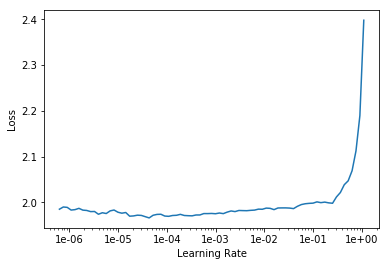

In [293]:
# emotion_classifier_learner.recorder.plot()

In [301]:
# emotion_classifier_learner.fit_one_cycle(10, 1e-1, wd=1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.956946,1.972258,0.152926,1:16:26
1,2.015434,1.979326,0.144282,1:15:10
2,2.039164,1.995777,0.143617,8:15:16
3,2.029626,2.070514,0.142952,8:53:50
4,2.004083,2.018573,0.145612,01:06


Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/usr/local/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/local/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/local/anaconda3/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
  File "/usr/local/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/usr/local/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/local/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _

KeyboardInterrupt: 

In [297]:
# emotion_classifier_learner.save("emotion_classifier_first_cycle")

In [298]:
# emotion_classifier_learner.predict("The guy excitedly jumped in the air.")

(Category sadness,
 tensor(5),
 tensor([0.1434, 0.1431, 0.1261, 0.1207, 0.1718, 0.1722, 0.1227]))